MF815 Midterm Project - Bankruptcy Detection

George Kepertis

kepertis@bu.edu

https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

### For the code to run correctly, the specific versions of the libraries below have to be installed. If the versions are different, there is no guarantee the code will run correctly. Some cells may not even run at all.

In [1]:
!pip install tensorflow-addons --user
!pip install joblib --user
!pip install scikit-learn==0.22.2.post1 --user
!pip install imbalanced-learn==0.6.0 --user
!pip install delayed --user

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

In [3]:
directory = os.path.abspath('')
data_path = os.path.join(directory, 'data.csv')
data = pd.read_csv(data_path)
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Exploratory Data Analysis

Let us check for missing values

In [4]:
total_na = 0
for col in data.columns:
  null_in_col = data[col].isna().sum()
  total_na += null_in_col
  if null_in_col > 0:
    print(col,":",null_in_col)
print("Total number of null values:",total_na)

Total number of null values: 0


We have no missing values in the data so we do not need to fill or impute.

Now let us check the types of data we have:

In [5]:
data.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

There are no string columns, so we do not need to preprocess any strings using a OneHotEncoder or a LabelEncoder.

Now let us check for any duplicated rows

In [6]:
print("Number of duplictaed rows:",data.duplicated().sum())

Number of duplictaed rows: 0


Let's look at a histogram of each column

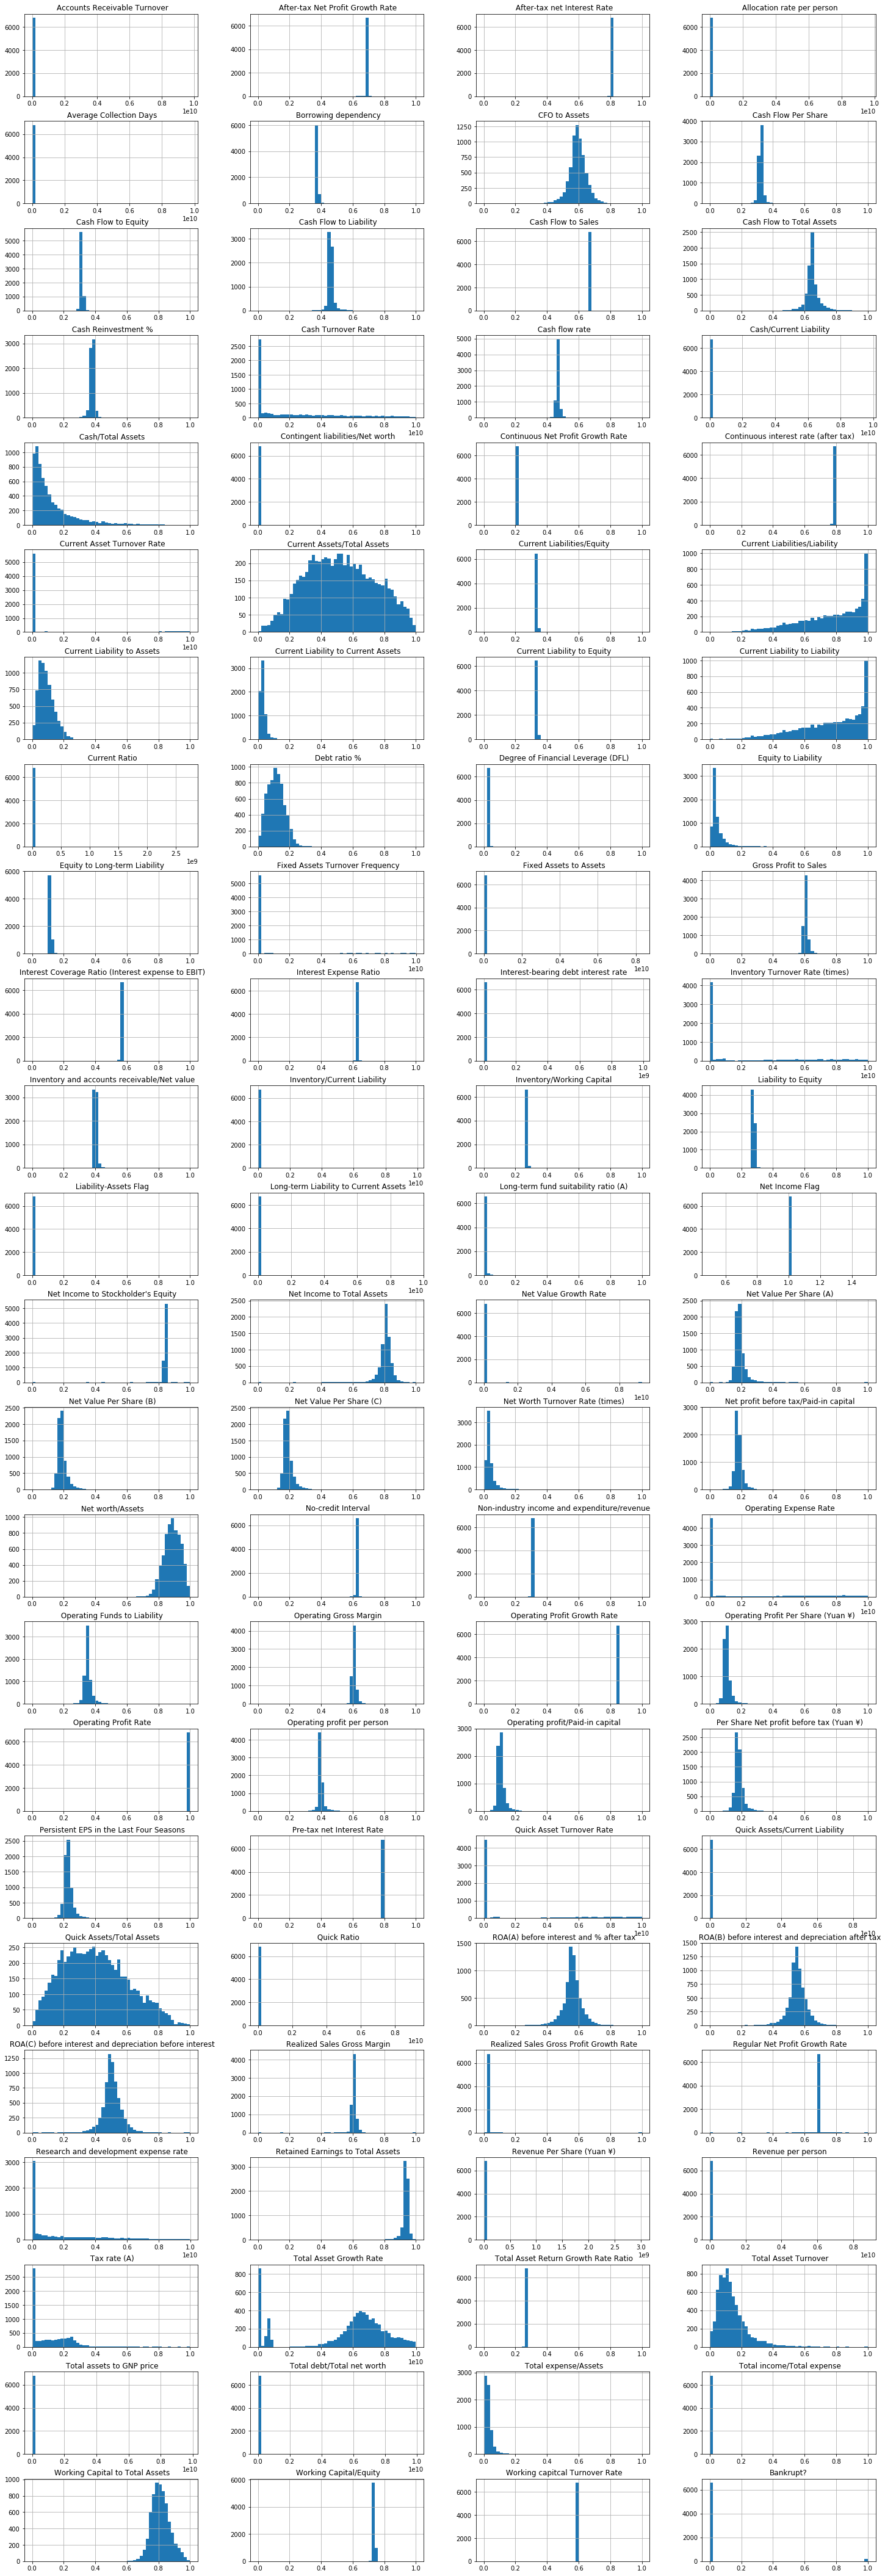

In [7]:
data.hist(layout = (25,4), figsize  = (25,80), bins = 50)
plt.show()

We can certainly see some distributions have outliers, while others are rather more uniform. While normally this would lead us to remove some of the outliers during the data processing stage, as we will see, the labels in the data are very imbalanced and what looks like an outlier may, in fact, be an indication of bankruptcy.

## Data Processing

Now we proceed to split our data into train and test. Due to the fact that we will be using cross validation, a validation test does not need to be specified explicitly.

In [8]:
from sklearn.model_selection import train_test_split

y = data['Bankrupt?']
X = data.drop(columns = ['Bankrupt?'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=815)

Let us now scale our data using a StandardScaler. This will make PCA give better results and just make the numbers smaller, thus giving the models somewhat of an easier time fitting.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Next, we use PCA for dimensionality reduction since the number of features we have is very high.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99,svd_solver = 'full', random_state = 815)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print("Number of kept features:", len(X_train[0]))

Number of kept features: 65


We see that if we keep 99% of the explained variance we are left with 65 out of 95 features. This is still a very high number, but if we remove more features we risk compromising performance.

Let's check the distribution of the label in the training set

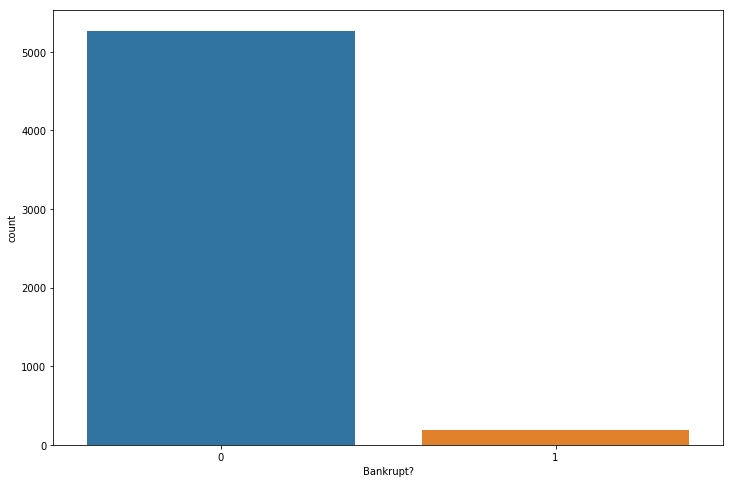

In [11]:
fig, ax  = plt.subplots(figsize = (12,8))
sns.countplot(data = pd.DataFrame(y_train),x = pd.DataFrame(y_train).columns[0], ax = ax)
plt.show()

We can see that our train set is very imbalanced. This will lead to poor performance if we do not compensate for it. We will need to either use an oversampling or undersampling technique. In the interest of training with more data, we will oversample, meaning we will randomly duplicate rows with label 1 and add them to our training set (this will be done by ADASYN https://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.ADASYN.html ). This will ensure that our model sees an equal amount of instances of both classes during training thus minimizing bias. To do this, we will use a Pipeline object from the imblearn library rather than sklearn. This will ensure that oversampling will only happen during the fit part of the pipeline, but not the validation set. Using an sklearn pipeline would use oversampled data in the validation set, which would result in results with much higher f1 score than the true score.
 
## Model Selection

Below we define a function that will automatically do what is described above (upsample only training, but not validation). We choose f1 as our default scoring for model selection since the validation sets will have the label imbalance in question thus making it the most appropriate metric for our problem. Furthermore, the function uses cross validation rather than one validation set, meaning we split our training set into train and validation at random several times and record the mean f1 score of each set of hyperparameters. The function then selects the model with the highest mean f1 score, fits the entire (upsampled) training set to it, and returns that trained model. We use 5-fold CV by default, but for some more computationally expensive algorithms we go down to 4 or 3 fold to speed up computation.

# Note
Almost all the cells in this section will have parts commented. Those are the parts that run the grid search algorithm to find the best model. The algorithm can take anywhere from 1 minute to 2 hours to find the best model. In the interest of saving time, the trained models are saved and are part of the submission (files with no extension). A cell at the end of this section loads all of the trained models using the joblib library.

In [12]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score


def best_model(X,y,base_model, params,scoring = 'f1', cv = 5):
    pipe = Pipeline(steps = [('ADASYN', ADASYN(random_state=815)), ('model', base_model)])
    params_pipe = [{'model__' + key: dictionary[key] for key in dictionary} for dictionary in params]
    cv_obj = KFold(cv)
    search = GridSearchCV(pipe,params_pipe,scoring = scoring,cv = cv_obj, n_jobs = -1, verbose = 2)
    search.fit(X,y)
    print("The best parameters were %s \nwith a mean CV %s score  of %f"\
          %(search.best_params_, scoring, search.best_score_))
    return search.best_estimator_

models = {}
keras_models = {}
model_names = ['Logistic Regression','Linear Discriminant Analysis',
               'Support Vector Machine','K-Neighbors','Multi-layer Perceptron', 
               'Random Forest','Gradient Boosting','Deep Neural Network - Dense (Keras + sklearn)']
keras_model_names =  ['Recurrent Neural Network - SimpleRNN (Keras)','Recurrent Neural Network - LSTM (Keras)',
              'Recurrent Neural Network - GRU (Keras)']

We can now proceed to training models

We begin by searching a grid of parameters for a Logistic Regression and we pick the best model by the mean cross validation score. We use 5-fold cross validation

In [13]:
from sklearn.linear_model import LogisticRegression

name = 'Logistic Regression'
C_values = [0.1,0.25,0.5,0.75,1,2.5,5,7.5,10,15,20,25,30,40,50]
class_weights = [None,'balanced']
penalties = ['l2','l1']
log_reg_params = [{'penalty' : penalties,'C':C_values,'class_weight':class_weights}]
# log_reg = best_model(X_train,y_train,LogisticRegression(random_state = 815, max_iter=500,n_jobs=-1),log_reg_params)
# joblib.dump(log_reg,name)
# models[name] = log_reg

Now we fit Linear and Quadratic Discriminant Analysis models to the data

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

name = 'Linear Discriminant Analysis'
shrinkages  = [None, 'auto', 0.25,0.5,0.75]
lda_params = [{'shrinkage':shrinkages}]
# lda  = best_model(X_train, y_train,LinearDiscriminantAnalysis(),lda_params)
# joblib.dump(lda,os.path.join(directory + '\\models', name))
# models[name] = lda

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

name = 'Test Model'
shrinkages  = [None, 'auto', 0.25,0.5,0.75]
lda_params = [{'shrinkage':shrinkages}]
# lda  = best_model(X_train, y_train,LinearDiscriminantAnalysis(),lda_params)
# joblib.dump(lda,os.path.join(directory + '\\models', name))
# models[name] = lda

Next we do a grid search on a Support Vector Classifier

In [16]:
from sklearn.svm import SVC

name = 'Support Vector Machine'
C_values = [0.1,0.5,1,5,10]
kernels = ['linear', 'rbf', 'sigmoid','poly']
gammas = ['scale', 'auto']
degrees = [2,3]
svc_params = [{'kernel':kernels[:-1],'C': C_values, 'gamma':gammas },
              {'kernel':[kernels[-1]],'C': C_values, 'gamma':gammas, 'degree':degrees }]
# svc = best_model(X_train,y_train,SVC(random_state = 815,probability=True),svc_params,cv = 3)
# joblib.dump(svc,os.path.join(directory + '\\models', name))
# models[name] = svc

Now we look at a K Neighbors Classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier

name = 'K-Neighbors'
n_values = [2,3,5,7,10,20,50]
weights = ['uniform', 'distance']
p = [1,2,3]
knn_params = [{'n_neighbors':n_values,'weights': weights, 'p':p }]
# knn = best_model(X_train,y_train,KNeighborsClassifier(n_jobs = -1),knn_params,cv = 5)
# joblib.dump(knn,os.path.join(directory + '\\models', name))
# models[name] = knn

Next we look at a simple, fully connected neural net implementation in sklearn, the Multi-layer Perceptron classifier

In [18]:
from sklearn.neural_network import MLPClassifier

#we try some random combinations here as running a lot of combinations would take hours
name = 'Multi-layer Perceptron'
n_neurons = [(8,),(16,),(32,),(64,),(16,8),(16,16,8),
             (16,16,16,16),(32,32,32,16),(64,64,64,64,32,16),(64,64,64,32)] 
activations = [ 'logistic', 'tanh', 'relu']
mlp_params = [{'hidden_layer_sizes':n_neurons,'activation': activations}]
# mlp = best_model(X_train,y_train,MLPClassifier(random_state = 815),mlp_params,cv = 5)
# joblib.dump(mlp,os.path.join(directory + '\\models', name))
# models[name] = mlp

Next we look at a Deep Neural network implementation in Keras, but we wrap the neural net inside of an sklearn classifier to allow us to perform a grid search cross validation. This gives us more flexibility in terms of choosing our layers and adding things like dropout. 

Note that the code in the cell directly below is a fix found at https://github.com/tensorflow/tensorflow/issues/34697 to make the Keras model picklable, meaning we are able to save it to avoid having to retrain every time.

In [19]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import pickle
from tensorflow.keras.models import  Model
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = tf.keras.models.Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

We start with a fully connected Dense neural network

In [20]:
name = 'Deep Neural Network - Dense (Keras + sklearn)'
def build_dnn(activation_funcs, neurons,dropout_rate = 0.4):
    dnn_model = tf.keras.models.Sequential()
    for num, (act, n_neurons) in enumerate(zip(activation_funcs,neurons)):
      if num == 0:
        dnn_model.add(tf.keras.layers.Dense(n_neurons,input_shape = (len(X_train[0]),) ,activation = act))
        dnn_model.add(tf.keras.layers.Dropout(dropout_rate))
      else:
        dnn_model.add(tf.keras.layers.Dense(n_neurons ,activation = act))
        dnn_model.add(tf.keras.layers.Dropout(dropout_rate))
    dnn_model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    # dnn_model.summary()
    dnn_model.compile(loss='binary_crossentropy', optimizer='adam', 
                      metrics=tfa.metrics.F1Score(num_classes=2, average = 'micro',threshold=0.5))
    return dnn_model

act_fns = [('tanh','tanh','tanh','tanh','tanh','tanh'),('relu','relu','relu','relu','relu','relu')]
neurons = [(512,256,128,64,32,16),(1024,512,256,128,64,32)]
dropout_rates = [0.3,0.4,0.5]
dnn_params = [{'activation_funcs':act_fns, 'dropout_rate':dropout_rates, 'neurons':neurons}]
# dnn = best_model(X_train, y_train, KerasClassifier(build_fn=build_dnn,epochs=100, batch_size=128, 
#                                                    verbose=0),dnn_params, cv = 3)
# joblib.dump(dnn,os.path.join(directory + '\\models', name))
# models[name] = dnn

We can also look at some Recurrent Neural Networks (Simple RNN, LSTM and GRU), though it is unlikely they will achieve great performance in this sort of classification problem. We will not be performing grid searches on these as they are not our main focus.

To use these models, we need to reshape our data in the format (samples, time steps, features). Since we only have one timestep, we keep the first dimension as is, we set the second dimension to 1 and make the third dimension 65, which is the number of features we have.

We also define a function that build the RNN for us to avoid repeating this process for each of the 3 types

In [21]:
X_rnn_train, y_rnn_train = ADASYN(random_state=815).fit_resample(X_train, y_train)
X_rnn_train = X_rnn_train.reshape(X_rnn_train.shape[0],1,X_rnn_train.shape[1])
X_rnn_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

def build_rnn(layer_name,neurons, dropout):
    rnn_model = tf.keras.models.Sequential()
    rnn_model.add(layer_name(neurons))
    rnn_model.add(tf.keras.layers.Dropout(dropout))
    rnn_model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    rnn_model.compile(loss='binary_crossentropy', optimizer='adam', 
                      metrics=tfa.metrics.F1Score(num_classes=2, average = 'micro',threshold=0.5))
    return rnn_model

In [22]:
name = 'Recurrent Neural Network - SimpleRNN (Keras)'
# srnn = build_rnn(tf.keras.layers.SimpleRNN, 64,0.45)
# srnn.fit(X_rnn_train,y_rnn_train, epochs = 100,batch_size=256)
# keras_models[name] = srnn
# joblib.dump(srnn,os.path.join(directory + '\\models', name))


In [23]:
name = 'Recurrent Neural Network - LSTM (Keras)'
# lstm = build_rnn(tf.keras.layers.LSTM,18, 0.5)
# lstm.fit(X_rnn_train,y_rnn_train, epochs = 100,batch_size=256)
# keras_models[name] = lstm
# joblib.dump(lstm,os.path.join(directory + '\\models', name))

In [24]:
name = 'Recurrent Neural Network - GRU (Keras)'
# gru = build_rnn(tf.keras.layers.GRU,16, 0.5)
# gru.fit(X_rnn_train,y_rnn_train, epochs = 100,batch_size=256)
# predictions = (gru.predict(X_rnn_test) > 0.5).astype("int32")
# print(f1_score(y_test,predictions))
# keras_models[name] = gru
# joblib.dump(gru,os.path.join(directory + '\\models', name))

As a bonus, let us look at some other classifiers not discussed in class. We will look at Random Forests and Gradient Boosting classifiers.

In [25]:
from sklearn.ensemble import RandomForestClassifier

name = 'Random Forest'
criterion = ['gini','entropy']
n_estimators = [50,100,200,250]
min_samples_split = [2,4,6,8,10]
min_samples_leaf = [1,2,5,10]
rfc_params = [{'n_estimators':n_estimators,'min_samples_split': min_samples_split, 
               'min_samples_leaf':min_samples_leaf, 'criterion':criterion}]
# rfc = best_model(X_train,y_train,RandomForestClassifier(random_state = 815,n_jobs = -1),rfc_params,cv = 5)
# joblib.dump(rfc,os.path.join(directory + '\\models', name))
# models[name] = rfc

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

name = 'Gradient Boosting'
loss = ['deviance', 'exponential']
n_estimators = [50,100,200]
min_samples_split = [2,4,6,8]
min_samples_leaf = [1,2,5,10]
gbc_params = [{'loss':loss,'n_estimators':n_estimators,'min_samples_split': min_samples_split,
               'min_samples_leaf':min_samples_leaf}]
# gbc = best_model(X_train,y_train,GradientBoostingClassifier(random_state = 815),gbc_params,cv = 3)
# joblib.dump(gbc,os.path.join(directory + '\\models', name))
# models[name] = gbc

## Model Loading 

To avoid having to run all of the GridSearchCV functions, below we can simply load the trained models

In [27]:
for name in model_names:
  if name not in models:
    model_path = os.path.join(directory + '\\models', name)
    models[name] =  joblib.load(model_path )
for name in keras_model_names:
  if name not in models:
    model_path = os.path.join(directory+ '\\models', name)
    keras_models[name] =  joblib.load(model_path)

## Results
Below we define a function that will summarize the results from all the models for us

In [28]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, \
confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from IPython.display import display

def summarize_results(models_dict, keras_models_dict,testing_x, testing_y):
    accuracies = []
    balanced_accuracies = []
    f1_scores = []
    auc_scores = []
    plt.figure(figsize=(14, 9))
    plt.plot([0, 1], [0, 1], 'k--') #diagonal
    print('                       ↓ Individual Classification Reports ↓ \n'+94*'-')
    for model in models_dict:
        print(model,"\n")
        prediction = models_dict[model].predict(testing_x)
        accuracies.append(accuracy_score(testing_y,prediction))
        balanced_accuracies.append(balanced_accuracy_score(testing_y,prediction))
        f1_scores.append(f1_score(testing_y,prediction))
        auc_scores.append(roc_auc_score(testing_y,prediction))
        probs = models_dict[model].predict_proba(testing_x)[:, 1]
        fpr, tpr, _ = roc_curve(testing_y,probs)
        plt.plot(fpr, tpr, label=model)
        print(classification_report(testing_y,prediction))
        print(94*'-')
    
    testing_x_rnn = testing_x.reshape(testing_x.shape[0],1,testing_x.shape[1])
    
    for model in keras_models_dict:
        print(model,"\n")
        probs = keras_models_dict[model].predict(testing_x_rnn)
        prediction = (probs > 0.5).astype("int32")
        accuracies.append(accuracy_score(testing_y,prediction))
        balanced_accuracies.append(balanced_accuracy_score(testing_y,prediction))
        f1_scores.append(f1_score(testing_y,prediction))
        auc_scores.append(roc_auc_score(testing_y,prediction))
        fpr, tpr, _ = roc_curve(testing_y,probs)
        plt.plot(fpr, tpr, label=model)
        print(classification_report(testing_y,prediction))
        print(94*'-')

    print('                       ↓ Summary of models (Sorted by f1 score) ↓ ')
    summary = pd.DataFrame(data = [accuracies,balanced_accuracies,f1_scores,auc_scores], 
                           columns=list(models_dict.keys())+ list(keras_models_dict.keys()), 
                           index = ['accuracy', 'balanced accuracy','f1 score','ROC AUC Score']).T
    display(summary.sort_values(by = ['f1 score'],ascending=False))
    print("\n"+94*'-'+"\n")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves')
    plt.legend(loc='lower right', prop={'size': 12})
    plt.show()

                       ↓ Individual Classification Reports ↓ 
----------------------------------------------------------------------------------------------
Logistic Regression 

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1329
           1       0.15      0.91      0.26        35

    accuracy                           0.87      1364
   macro avg       0.57      0.89      0.59      1364
weighted avg       0.98      0.87      0.91      1364

----------------------------------------------------------------------------------------------
Linear Discriminant Analysis 

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1329
           1       0.12      0.89      0.22        35

    accuracy                           0.84      1364
   macro avg       0.56      0.86      0.56      1364
weighted avg       0.97      0.84      0.89      1364

-----------------------------------------

C:\Users\jojis\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\jojis\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1329
           1       0.25      0.86      0.38        35

    accuracy                           0.93      1364
   macro avg       0.62      0.89      0.67      1364
weighted avg       0.98      0.93      0.95      1364

----------------------------------------------------------------------------------------------
Recurrent Neural Network - LSTM (Keras) 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1329
           1       0.31      0.66      0.42        35

    accuracy                           0.95      1364
   macro avg       0.65      0.81      0.70      1364
weighted avg       0.97      0.95      0.96      1364

----------------------------------------------------------------------------------------------
Recurrent Neural Network - GRU (Keras) 

              precision    recall  f1-score   support

           0      

,accuracy,balanced accuracy,f1 score,ROC AUC Score
Deep Neural Network - Dense (Keras + sklearn),0.964076,0.759013,0.436782,0.759013
Random Forest,0.961144,0.771418,0.430108,0.771418
Recurrent Neural Network - LSTM (Keras),0.953812,0.809384,0.422018,0.809384
Support Vector Machine,0.950147,0.807503,0.403509,0.807503
Recurrent Neural Network - GRU (Keras),0.947947,0.820284,0.403361,0.820284
Recurrent Neural Network - SimpleRNN (Keras),0.929619,0.894335,0.384615,0.894335
Gradient Boosting,0.937683,0.787198,0.341085,0.787198
Multi-layer Perceptron,0.955279,0.684951,0.314607,0.684951
K-Neighbors,0.942815,0.692465,0.277778,0.692465
Logistic Regression,0.866569,0.889799,0.260163,0.889799



----------------------------------------------------------------------------------------------



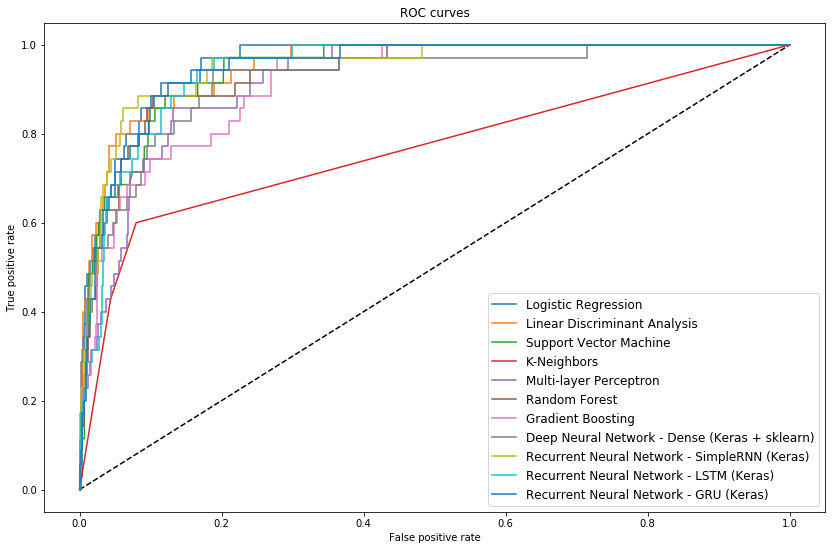

In [30]:
summarize_results(models,keras_models,X_test,y_test)

### Note:
The warning with Deep Neural Network - Dense (Keras + sklearn) is due to the fact that a Keras NN is being wrapped in an sklearn object which then calls the predict method. This is no longer the correct way of getting predictions for keras NNs (the correct method is seen in the summarize_results function for the other 3 NNs), however it does work with the versions of sklearn, tensorflow and keras that are specified at the beginning of the notebook, meaning we can ignore this warning as long as the correct versions are used.

## Discussion

As we can see from above, the Random Forest and the Dense DNN have the best accuracies and f1 scores. It is possible that there are other models that were not considered in this notebook that will perform marginally better. It is also almost certain, that there is an architecture for either a DNN or an RNN (all 3 of which had decent performance) that can further raise f1 score. However, to find such an architecture, we would have to perform extensive grid searches for hyperparameter tuning that are extremely computationally expensive. Such a process would take days, if not weeks on a personal computer. Ideally, this would be done on a virtual machine that is part of a cluster located on a cloud. However, with the machinery at hand and considering the fact that this is such an imbalanced dataset, an f1 score of 0.437 with an accuracy of 0.964 can be considered a decent result.